In [1]:
import umap
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap
from sklearn import linear_model
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
from useful_funcs import load_df  # , fft_river_df
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import time
import gc
from sklearn.manifold import TSNE

start_globals = set(globals().keys())

# -- River height --
river_depth_df = load_df('ingested_data/river_depth_data.csv')
river_depth_df = river_depth_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')

# -- Precipitation --
precip_df = load_df('ingested_data/precip_data.csv')
precip_df2 = load_df('ingested_data/precip_data2.csv')

# if na can only make better by looking at next nearest df
for riv in list(precip_df):
    hashmap_for_orig = precip_df[riv].isna()
    precip_df.loc[hashmap_for_orig,
                  riv] = precip_df2.loc[hashmap_for_orig, riv]
precip_df = precip_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')

# -- Temperature --
temp_df = load_df('ingested_data/temp_data.csv')
temp_df2 = load_df('ingested_data/temp_data2.csv')

# if na can only make better by looking at next nearest df
for riv in list(temp_df):
    hashmap_for_orig = temp_df[riv].isna()
    temp_df.loc[hashmap_for_orig,
                riv] = temp_df2.loc[hashmap_for_orig, riv]
temp_df = temp_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')


In [2]:
imperfect_final_rivs = []  # for train and validate
with open('eda_results/imperfect_final_rivs.txt', 'r') as in_file:
    imperfect_final_rivs = in_file.readline()[:-1].split(', ')
perfect_final_rivs = []  # for final test
with open('eda_results/perfect_final_rivs.txt', 'r') as in_file:
    perfect_final_rivs = in_file.readline()[:-1].split(', ')


# df name shortening:
# letter 1 = d (river depth), p (precipitation), t (temperature)
# letter 2 = i (imperfect), p (perfect)
di_df = river_depth_df.loc[:, imperfect_final_rivs]
pi_df = precip_df.loc[:, imperfect_final_rivs]
ti_df = temp_df.loc[:, imperfect_final_rivs]
dp_df = river_depth_df.loc[:, perfect_final_rivs]
pp_df = precip_df.loc[:, perfect_final_rivs]
tp_df = temp_df.loc[:, perfect_final_rivs]


In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

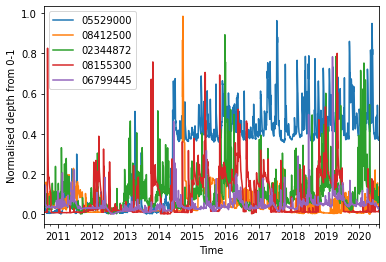

In [4]:
dtrain_df = di_df.loc[:, train_rivs]
normed_01_d_df = (dtrain_df - dtrain_df.min()) / dtrain_df.max()
normed_01_d_df.iloc[:, :5].plot()
plt.ylabel('Normalised depth from 0-1')
plt.xlabel('Time')
plt.show()
mean_std_d_df = (dtrain_df - dtrain_df.mean()) / dtrain_df.std()

In [5]:
# Check frequencies in data
# not clear there is pattern any apart from yearly
# fft_river_df(dtrain_df, 'depth')
# fft_river_df(pi_df.loc[:, train_rivs], 'precipitation')
# fft_river_df(ti_df.loc[:, train_rivs], 'temperature')

In [6]:
# Autocorrelation functions and data processing
print('--- Autocorrelation functions and data processing ---')
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]


def d_autocorr_mean(row):
    return dtrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


def p_autocorr_mean(row):
    return ptrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


def t_autocorr_mean(row):
    return ttrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


print('Depth')
d_autocorrs = process_map(d_autocorr_mean, range(
    dtrain_df.shape[0]-2), max_workers=16, chunksize=5)
print('Precipitation')
p_autocorrs = process_map(p_autocorr_mean, range(
    ptrain_df.shape[0]-2), max_workers=16, chunksize=5)
print('Temperature')
t_autocorrs = process_map(t_autocorr_mean, range(
    ttrain_df.shape[0]-2), max_workers=16, chunksize=5)

--- Autocorrelation functions and data processing ---
Depth


100%|██████████| 3652/3652 [06:54<00:00,  8.82it/s]

Precipitation



100%|██████████| 3652/3652 [06:39<00:00,  9.14it/s]

Temperature



100%|██████████| 3652/3652 [06:35<00:00,  9.23it/s]


--- Autcorrelation graphs ---
Depth


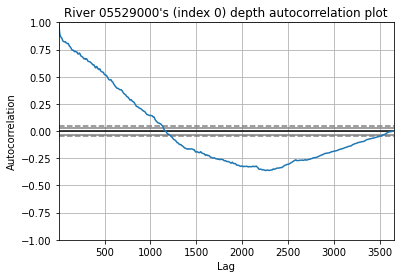

Each river is unique so find mean of all rivers from now on


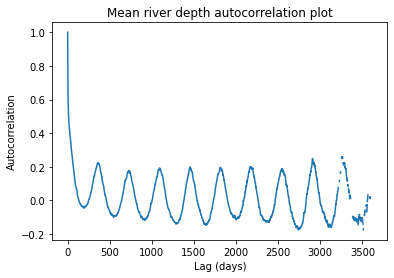

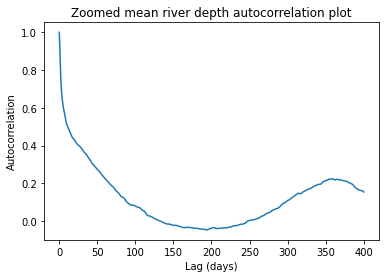

Precipitation


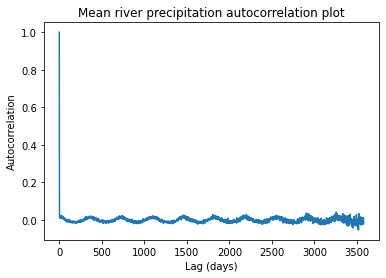

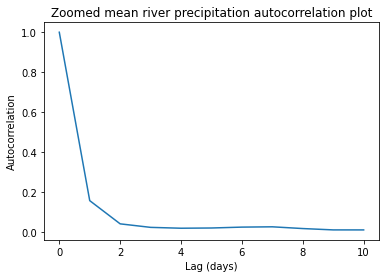

Temperature


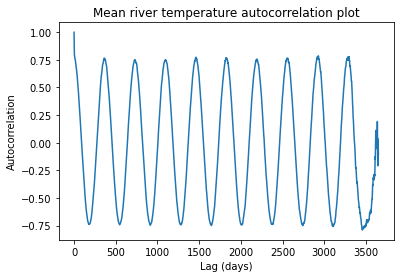

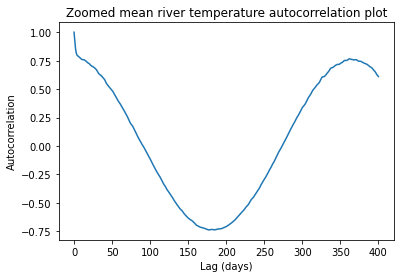

In [7]:
# Autocorrelation graphs
# DEPTH
# 1 river
print('--- Autcorrelation graphs ---')
print('Depth')
pd.plotting.autocorrelation_plot(dtrain_df.iloc[:, 0])
plt.title(f"River {list(dtrain_df)[0]}'s (index 0) depth autocorrelation plot")
plt.show()
print(f"Each river is unique so find mean of all rivers from now on")

# All rivers
plt.plot(d_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river depth autocorrelation plot')
plt.show()

# Zoomed in all rivers
plt.plot(d_autocorrs[:401])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river depth autocorrelation plot')
plt.show()

# PRECIPITATION
print('Precipitation')
# All rivers
plt.plot(p_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river precipitation autocorrelation plot')
plt.show()

# Zoomed in all rivers
plt.plot(p_autocorrs[:11])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river precipitation autocorrelation plot')
plt.show()

# TEMPERATURE
# All rivers
print('Temperature')
plt.plot(t_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river temperature autocorrelation plot')
plt.show()

# Zoomed in all rivers
plt.plot(t_autocorrs[:401])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river temperature autocorrelation plot')
plt.show()



In [8]:
# Make training, validate, testing matrices for df in next step
slide_train_arr = []    # train features
slide_val_arr = []      # validate features
slide_test_arr = []      # test features
data_days = 20
future_days = 14
rolling_period = data_days+future_days

# Considered this but 2x as fast for much uglier code so changed back
# https://stackoverflow.com/questions/47483579/how-to-use-numpy-as-strided-from-np-stride-tricks-correctly/47483615#47483615
# def custom_rolling(a, length):
#     return np.lib.stride_tricks.as_strided(a, (len(a) - (length-1), length), a.strides*2, writeable=False)


def slide_window_riv(riv):
    imp = riv in imperfect_final_rivs
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []
    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        feature_data = np.concatenate(
            (rd.values[:data_days], rp.values[:data_days], rt.values[:data_days]))
        features = [rd.values[-1], riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


# https://stackoverflow.com/questions/37804279/how-can-we-use-tqdm-in-a-parallel-execution-with-joblib
all_slide_window_data = process_map(slide_window_riv, imperfect_final_rivs + perfect_final_rivs,
                                    max_workers=16, chunksize=10)

for all_features in tqdm(all_slide_window_data, 'Reassigning river data to correct frame'):
    for features in all_features:
        riv = features[1]
        if riv in train_rivs:
            slide_train_arr.append(features)
        elif riv in validate_rivs:
            slide_val_arr.append(features)
        else:
            slide_test_arr.append(features)


  0%|          | 0/1816 [00:26<?, ?it/s]


In [ ]:
# https://stackoverflow.com/questions/3543833/how-do-i-clear-all-variables-in-the-middle-of-a-python-script
currglobals = list(globals().keys())
time.sleep(1)
for key in currglobals:
    if key not in {'currglobals', 'start_globals', 'slide_train_arr', 'slide_val_arr', 'slide_test_arr', 'data_days', 'future_days', 'rolling_period'} | start_globals:
        exec('del ' + key)
_ = gc.collect()
print('Garbage collected')

In [ ]:
# create dfs and sort because all out of order!
slide_cols = ['y', 'river', 'river_day']
for idx in range(data_days):
    slide_cols.append(f'd{idx}')
for idx in range(data_days):
    slide_cols.append(f'p{idx}')
for idx in range(data_days):
    slide_cols.append(f't{idx}')

In [ ]:
X_train_df = pd.DataFrame(slide_train_arr, columns=slide_cols)
print('Training data made')
X_train_df.sort_values(by=['river', 'river_day'], inplace=True)
print('Training data sorted')

In [ ]:
X_val_df = pd.DataFrame(slide_val_arr, columns=slide_cols)
print('Validation data made')
X_val_df.sort_values(by=['river', 'river_day'], inplace=True)
print('Validation data sorted')

In [ ]:
X_test_df = pd.DataFrame(slide_test_arr, columns=slide_cols)
print('Test data made')
X_test_df.sort_values(by=['river', 'river_day'], inplace=True)
print('Test data sorted')


In [ ]:
# cleanup unused data
for var_name in ['slide_train_arr', 'slide_val_arr', 'slide_test_arr']:
    exec('del ' + var_name)
_ = gc.collect()

In [ ]:
# --- LASSO model ---
clf = linear_model.Lasso(alpha=0.1)
clf = clf.fit(X_train_df.iloc[:, 3:], X_train_df['y'])
score = clf.score(X_val_df.iloc[:, 3:], X_val_df['y'])
print('R2 score for linear regression model:', score)
# - 20 days of data predicting 14 days in future -
# R2 score for linear regression model: 0.9992265647557013
# - 7 days of data predicting 30 days in future -
# R2 score for linear regression model: 0.9989407592400386

In [ ]:
# Day 34 = depth what we are predicting
# We have depth
fig, ax = plt.subplots()
plt.plot(clf.coef_)
plt.xticks(range(data_days*3)[::5], slide_cols[3:][::5])
plt.ylabel('Coefficients')
plt.xlabel('Feature names')
plt.title(f'Coefficient weights for lasso model with R2={score:.2f}')
plt.show()



In [ ]:
pred = clf.predict(X_val_df.iloc[:, 3:])
med_abs_err = median_absolute_error(X_val_df['y'], pred)
print(f'Median abs error: {med_abs_err:.2f}')
# - 20 days of data predicting 14 days in future -
# Median abs error: 0.31
# - 7 days of data predicting 30 days in future -
# Median abs error: 0.37

In [ ]:
# from SML312_P6_classification_methods
# doesn't work for millions of entries
# https://umap-learn.readthedocs.io/en/latest/benchmarking.html
# X_test_emb = TSNE(n_components=2, learning_rate='auto',init='pca', angle=0.65, n_jobs=-1, verbose=1, n_iter=300, perplexity=50, random_state=42).fit_transform(X_train_df.iloc[:, 3:28])
# Only use best features from lasso
X_train_emb = PCA(n_components=2).fit_transform(X_train_df.iloc[:, 3:28])
print('lower dim embedding made, now plotting')
plt.scatter(X_train_emb[:, 0], X_train_emb[:, 1], s=3, c=X_train_df['y'])
plt.title('True labels for test set if PCA reduced')
plt.colorbar()
plt.show()

print('Finding prediction error')
train_pred_pca = clf.predict(X_train_df.iloc[:, 3:])
print('Prediction error found, now plotting')

plt.scatter(X_train_emb[:, 0], X_train_emb[:, 1],
            s=3, c=X_train_df['y']-train_pred_pca)
plt.title('True - predicted')
plt.colorbar()
plt.show()

In [ ]:
rows = 100000  # of 2million
umap_reducer = umap.UMAP(n_neighbors=80, n_epochs=250, n_jobs=-1)
X_train_emb_umap = umap_reducer.fit_transform(X_train_df.iloc[:rows, 3:28])

plt.scatter(X_train_emb_umap[:, 0][:rows], X_train_emb_umap[:, 1][:rows], s=3,
            c=X_train_df['y'][:rows]-train_pred_pca[:rows])
plt.title('True - predicted')
plt.colorbar()
plt.show()